# C14-hepatocyte analysis

In [1]:
# m = c14.models.liver.A()

# path = c14.models.liver.default_path

# from scipy.interpolate import UnivariateSpline

# ploidy_data = pd.read_excel(path)
# ploidy_data['age'] = (ploidy_data[['age_min', 'age_max']].
#                       mean(axis='columns'))
# ploidy_data /= 100.0
# ploidy_data['age'] *= 100

# ploidy = UnivariateSpline(ploidy_data['age'].values,
#                                ploidy_data['2C_mean'].values,
#                                ext=3, k=2)

# t = np.linspace(0, 100)
# plt.plot(t, m.ploidy(t))
# plt.plot(t, ploidy(t))

default_parameters -> fit

default_limit -> physical

parameters -> physical

In [2]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline

mem = joblib.Memory(location='/scratch/tmp/fabrost/hepato', verbose=0)

import logging

%load_ext rpy2.ipython

# logging.basicConfig(filename='c14.log',
#                              filemode='a',
#                              format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                              level=logging.DEBUG)
logging.basicConfig(level=logging.WARNING)

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [4]:
# %load_ext autoreload
# %autoreload 2
import c14
import c14.models.liver
import c14.models.minimal

## Data

In [5]:
data = pd.read_csv('../../../results/C14data_liver_samples_20191023.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != "Y"')
edata = c14.exp_data(data)

In [6]:
edata_young = c14.exp_data(data.query('age <= 50'))
edata_old = c14.exp_data(data.query('age > 50'))

## Fit the models

In [7]:
@mem.cache
def fit_model(edata, model, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    print(f'Fitting model {model.__name__}')
    result = {'model': model()}
    result['op'] = c14.optimize(model=result['model'],data=edata,step_size=step_size)
    result['vis'] = c14.visualisze(model=result['model'],data=edata,step_size=step_size)
    result['multistart_result'] = result['op'].optimize_minuit_multistart(**optimize_minuit_multistart_kwargs)
    try:
        result['point_estimate'] = result['multistart_result'].sort_values('fval').iloc[0]['values']
        result['cov'] = result['multistart_result'].sort_values('fval').iloc[0]['cov']
    except:
        print(f'Multistart found no valid results for model {model.__name__}')
    try:
        result['errors'] = result['vis'].calc_error(result['point_estimate'], result['cov'], ignore_physics=True)
    except:
        print(f'Could not calculate errors for {model.__name__}')
    return result

In [8]:
def fit_models(edata, models, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    results = {model.__name__: fit_model(edata, model, step_size, optimize_minuit_multistart_kwargs)
               for model in models}
    return results

In [9]:
models = c14.models.liver.models_list + [c14.models.minimal.POP1]
models

[c14.models.liver.D,
 c14.models.liver.R,
 c14.models.liver.K,
 c14.models.liver.R2K24,
 c14.models.minimal.POP1]

In [10]:
init_limit = {'r2': (-3, 0), 
              'r2_0': (-3, 0), 
              'r2_100': (-3, 0), 
              'r4': (-3, 0),
              'lambda2': (-3, 0),
              'lambda4': (-3, 0),
              'kappa24': (-3, 0),
              'kappa24_0': (-3, 0),
              'kappa24_100': (-3, 0),
              'kappa42': (-3, 0),
              'delta2': (-3, 0),
              'delta2_0': (-3, 0),
              'delta2_100': (-3, 0),
              'delta4': (-3, 0),
              'f': (1, 3),
              'lambda_': (-3, 0),
              'r2_0': (-3, 0),
              'r2_1': (-3, 0),
              'r2_100': (-3, 0),
              't_step': (np.log10(5), np.log10(70))
             }

In [95]:
# %%time
# results = fit_models(edata, models, step_size=2, 
#                      optimize_minuit_multistart_kwargs=dict(n=10, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [96]:
# models = [c14.models.liver.R2K24]

In [97]:
# fit_model.clear()

In [98]:
%%time
results = fit_models(edata, models, step_size=0.5, 
                     optimize_minuit_multistart_kwargs=dict(n=100, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

CPU times: user 625 ms, sys: 7.31 ms, total: 632 ms
Wall time: 630 ms


In [99]:
# %%time
# results = fit_models(edata, models, step_size=0.5, 
#                      optimize_minuit_multistart_kwargs=dict(n=100, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [100]:
%%time
results_K_1000 = fit_models(edata, [c14.models.liver.K], step_size=0.5, 
                     optimize_minuit_multistart_kwargs=dict(n=1000, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

CPU times: user 1.16 s, sys: 23.7 ms, total: 1.19 s
Wall time: 1.18 s


In [101]:
results.update(results_K_1000)

In [102]:
# %%time
# results_young = fit_models(edata_young, models, step_size=0.5, 
#                      optimize_minuit_multistart_kwargs=dict(n=100, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [103]:
# %%time
# results_old = fit_models(edata_old, models, step_size=0.5, 
#                      optimize_minuit_multistart_kwargs=dict(n=100, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [104]:
def summarise(results):
    parameters = pd.concat(
        [result['vis'].get_parameter(result['point_estimate'], 
                                     result['cov'], 
                                     t_eval=[0, 80])
         .assign(model = name).reset_index() for name, result in results.items()
        ], ignore_index=True)

    parameters['point_estimate'] = parameters['point_estimate'].astype(float)
    parameters['lower'] = parameters['lower'].astype(float)
    parameters['upper'] = parameters['upper'].astype(float).replace(np.inf, 1e99)
    parameters['parameter'] = parameters['parameter'].astype(str)
    parameters['time'] = parameters['time'].astype(str)

    parameters['ymin'] = parameters['point_estimate'] - parameters['lower']
    parameters['ymax'] = parameters['upper'] - parameters['point_estimate']
    return parameters

In [105]:
parameters = summarise(results)
# parameters_young = summarise(results_young)
# parameters_old = summarise(results_old)

## Parameter Values

### Detailed

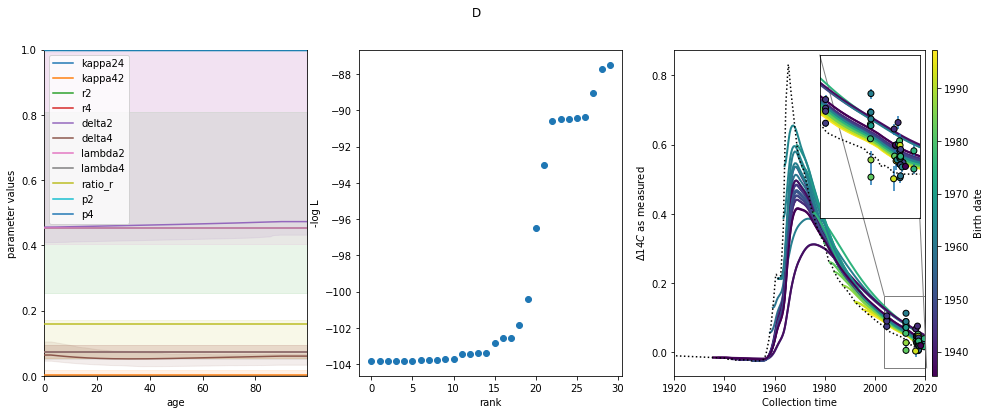

point_estimate        lower       upper
time parameter                                          
0    delta2            0.455732     0.400753    0.977761
     delta4           0.0636877    0.0446759   0.0976317
     kappa24        0.000100842  9.58529e-06  0.00106091
     kappa42         0.00164378  0.000163198   0.0165567
     lambda2           0.454189      0.39867    0.978915
     lambda4           0.073695    0.0525504   0.0888256
     p2                0.999778     0.997128    0.999721
     p4                0.999778     0.997128    0.999721
     r2                0.454088     0.254846    0.809101
     r4               0.0720512    0.0542265    0.095735
     ratio_kappa        16.3006     0.366299     45.2092
     ratio_r           0.158672    0.0531283    0.184071
50   delta2            0.463972     0.411227    0.988358
     delta4           0.0534592    0.0315827   0.0700256
     kappa24        0.000100842  9.58529e-06  0.00106091
     kappa42         0.00164378  0.000163198   0.0165567
     lambda2           0.454189     0.398696    0.982079
     lambda4           0.073695    0.0519524    0.088429
     p2                0.999778     0.997167    0.999721
     p4                0.999778     0.997167    0.999721
     r2                0.454088     0.254846    0.809101
     r4               0.0720512    0.0542265    0.095735
     ratio_kappa        16.3006     0.347405     44.9036
     ratio_r           0.158672    0.0526753    0.184044
80   delta2            0.470277     0.421807    0.996063
     delta4           0.0588288    0.0336053   0.0669239
     kappa24        0.000100842  9.58529e-06  0.00106091
     kappa42         0.00164378  0.000163198   0.0165567
     lambda2           0.454189      0.39867    0.979187
     lambda4           0.073695    0.0518502    0.088429
     p2                0.999778      0.99718    0.999721
     p4                0.999778      0.99718    0.999721
     r2                0.454088     0.254846    0.809101
     r4               0.0720512    0.0542265    0.095735
     ratio_kappa        16.3006     0.346678     44.9036
     ratio_r           0.158672    0.0531283    0.184071

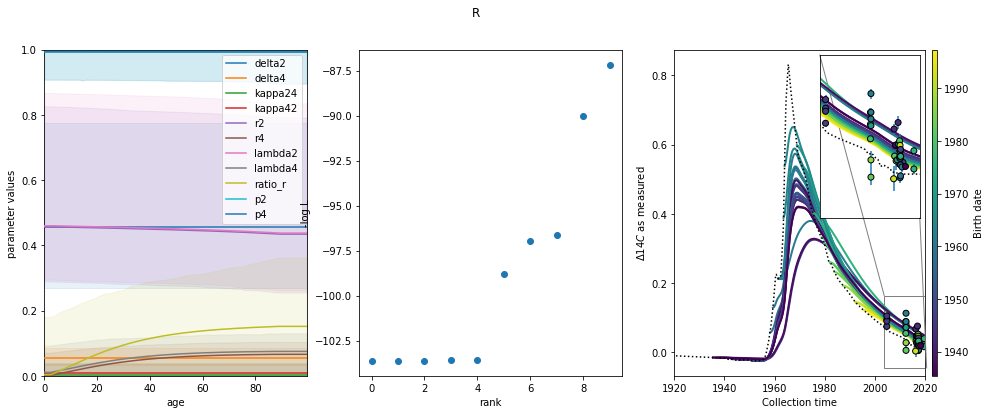

point_estimate        lower      upper
time parameter                                         
0    delta2            0.456277     0.268293   0.775976
     delta4           0.0539877     0.034562  0.0843318
     kappa24         0.00313471  0.000255643  0.0384381
     kappa42         0.00900677   0.00226437  0.0358254
     lambda2           0.460146     0.254365   0.738524
     lambda4          0.0105085    0.0299577   0.106878
     p2                0.993188     0.973404    0.99924
     p4                0.993188     0.973404    0.99924
     r2                0.457012     0.249845    0.73133
     r4              0.00150172    0.0175086  0.0835161
     ratio_kappa        2.87324     0.605212    37.5624
     ratio_r         0.00328595    0.0295214   0.280848
50   delta2            0.456277     0.268293   0.775976
     delta4           0.0539877     0.034562  0.0843318
     kappa24         0.00313471  0.000255643  0.0384381
     kappa42         0.00900677   0.00226437  0.0358254
     lambda2           0.450577     0.235321   0.729527
     lambda4          0.0664429    0.0659971   0.137204
     p2                0.993043     0.985408    0.99929
     p4                0.993043     0.985408    0.99929
     r2                0.447442     0.231197   0.724984
     r4               0.0574361    0.0563058    0.11062
     ratio_kappa        2.87324      1.07323    40.6731
     ratio_r           0.128365       0.0868   0.424962
80   delta2            0.456277     0.268293   0.775976
     delta4           0.0539877     0.034562  0.0843318
     kappa24         0.00313471  0.000255643  0.0384381
     kappa42         0.00900677   0.00226437  0.0358254
     lambda2            0.44154     0.215417   0.715038
     lambda4          0.0741075    0.0702421   0.144324
     p2                  0.9929     0.992239   0.999431
     p4                  0.9929     0.992239   0.999431
     r2                0.438405     0.214359   0.714849
     r4               0.0651007    0.0624574   0.118865
     ratio_kappa        2.87324      2.09396    55.2631
     ratio_r           0.148494    0.0928436    0.47026

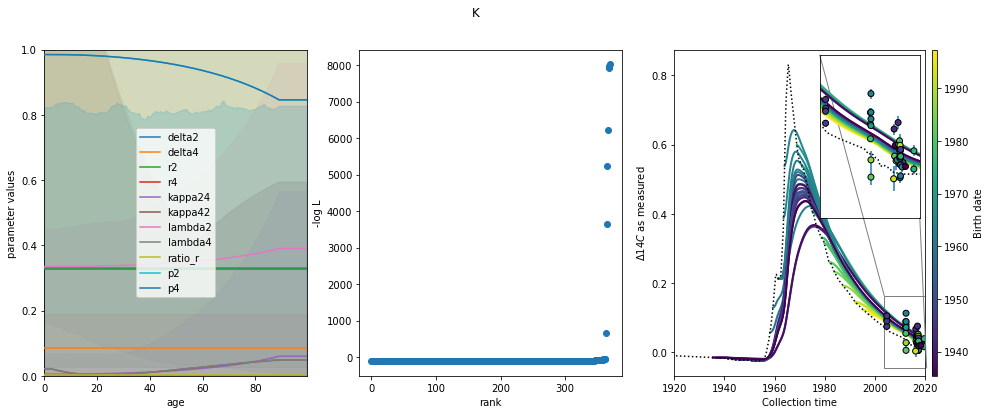

point_estimate        lower       upper
time parameter                                          
0    delta2            0.328602    0.0281945     3.82979
     delta4           0.0837022  3.43283e-16  2.0409e+13
     kappa24         0.00504622    0.0180194    0.148196
     kappa42          0.0213481     0.337139     1.60482
     lambda2           0.335196    0.0352688    0.681282
     lambda4           0.021928      0.38935     1.62707
     p2                0.984945     0.208161    0.815876
     p4                0.984945     0.208161    0.815876
     r2                 0.33015   0.00493595     22.0827
     r4             0.000579863  1.77094e-06    0.189866
     ratio_kappa        4.23051      10.8701     24.7057
     ratio_r         0.00175636  0.000472634     4.76159
50   delta2            0.328602    0.0281945     3.82979
     delta4           0.0837022  3.43283e-16  2.0409e+13
     kappa24          0.0160903     0.018675      1.1263
     kappa42          0.0185468     0.138476     3.76917
     lambda2           0.346241    0.0437285     1.62713
     lambda4          0.0191267     0.154631     3.76984
     p2                0.953528     0.226827    0.826909
     p4                0.953528     0.226827    0.826909
     r2                 0.33015   0.00493595     22.0827
     r4             0.000579863  1.77094e-06    0.189866
     ratio_kappa        1.15267      3.59378     7.55635
     ratio_r         0.00175636   0.00041714     1.08546
80   delta2            0.328602    0.0281945     3.82979
     delta4           0.0837022  3.43283e-16  2.0409e+13
     kappa24          0.0440789    0.0217646     4.96032
     kappa42          0.0426077    0.0530847     7.49967
     lambda2           0.374229      0.04703     5.60095
     lambda4          0.0431875    0.0637164     7.50037
     p2                0.882214     0.109776    0.861663
     p4                0.882214     0.109776    0.861663
     r2                 0.33015   0.00493595     22.0827
     r4             0.000579863  1.77094e-06    0.189866
     ratio_kappa       0.966623      1.54977     3.19061
     ratio_r         0.00175636   0.00038577    0.497758

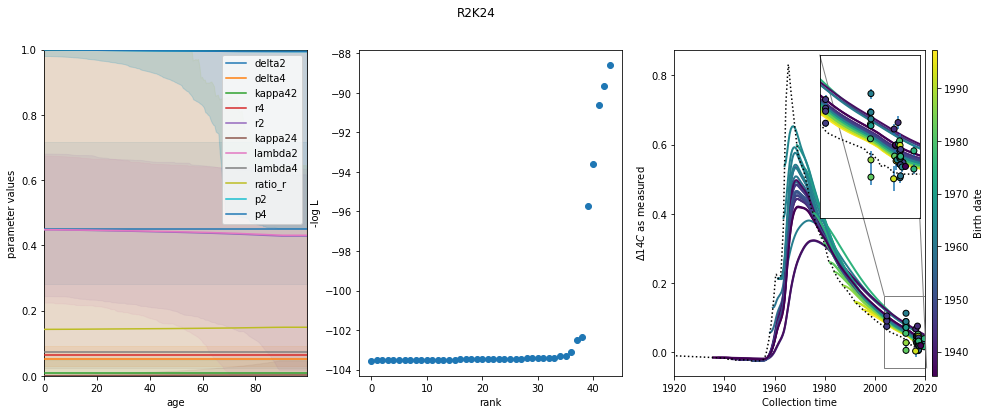

point_estimate       lower       upper
time parameter                                         
0    delta2            0.450021    0.282019    0.718103
     delta4            0.051467   0.0290712    0.091116
     kappa24        0.000205381  0.00149479  0.00601705
     kappa42          0.0079398  0.00133148   0.0473462
     lambda2           0.448126    0.286043    0.696923
     lambda4          0.0717159   0.0170934    0.107336
     p2                0.999542    0.979926    0.997347
     p4                0.999542    0.979926    0.997347
     r2                0.447921    0.281007    0.694188
     r4               0.0637761  0.00380369     1.06933
     ratio_kappa        38.6589     1.31292     18.9438
     ratio_r           0.142383  0.00271013    0.104645
50   delta2            0.450021    0.282019    0.718103
     delta4            0.051467   0.0290712    0.091116
     kappa24         0.00179647  0.00597297   0.0194099
     kappa42          0.0079398  0.00133148   0.0473462
     lambda2           0.441931    0.293659    0.699064
     lambda4          0.0717159   0.0169977    0.104265
     p2                0.995935    0.937856    0.989921
     p4                0.995935    0.937856    0.989921
     r2                0.440135    0.277166    0.688731
     r4               0.0637761  0.00380369     1.06933
     ratio_kappa        4.41967    0.393964     5.74596
     ratio_r           0.144901  0.00276126    0.102252
80   delta2            0.450021    0.282019    0.718103
     delta4            0.051467   0.0290712    0.091116
     kappa24         0.00240988   0.0128751   0.0437429
     kappa42          0.0079398  0.00133148   0.0473462
     lambda2           0.434517    0.314757    0.710375
     lambda4          0.0717159   0.0167037    0.101447
     p2                0.994454     0.87085     0.97815
     p4                0.994454     0.87085     0.97815
     r2                0.432107    0.273848    0.692424
     r4               0.0637761  0.00380369     1.06933
     ratio_kappa        3.29469    0.163496     2.50077
     ratio_r           0.147593  0.00283507   0.0953043

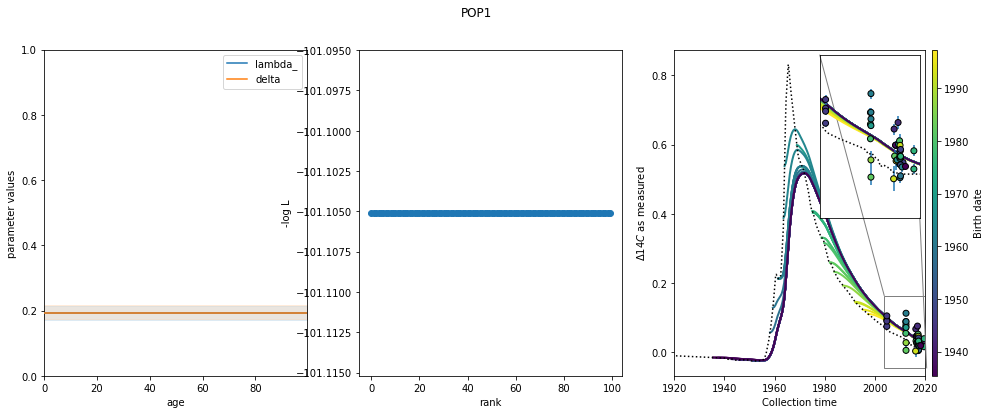

point_estimate     lower     upper
time parameter                                   
0    delta           0.192405  0.172215  0.214157
     lambda_         0.192405  0.172035  0.215187
50   delta           0.192405  0.172215  0.214157
     lambda_         0.192405  0.172035  0.215187
80   delta           0.192405  0.172215  0.214157
     lambda_         0.192405  0.172035  0.215187

In [106]:
for name, result in results.items():
    if name not in ['']:
        no_plot = ['ratio_kappa']
        fig, axs = plt.subplots(1, 3, figsize=(16,6))
        fig.suptitle(name)
        result['vis'].plot_parameter(result['point_estimate'], result['errors'],
                                         no_plot=no_plot, axis=axs[0])
#         result['vis'].plot_parameter(result['point_estimate'], 
#                                          no_plot=no_plot, axis=axs[0])

        axs[0].legend()
        axs[0].set_ylabel('parameter values')
        axs[0].set_ylim(0, 1)

        fval = result['multistart_result']['fval']
        axs[1].scatter(np.arange(len(fval)), fval.values)
        axs[1].set_xlabel('rank')
        axs[1].set_ylabel('-log L')
    #         axs[1].set_xlim(0, 100)
        
        _ = result['vis'].odeint()
        result['vis'].plot_simdata( axis=axs[2], cmap=plt.cm.viridis)
        axs[2].set_xlim(1920, 2020)

        plt.show()

        try:
            display(result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=[0, 50, 80]
                                               ))
        except:
            pass

### Summarized

In [46]:
parameters.query('model == "D"')

,time,parameter,point_estimate,lower,upper,model,ymin,ymax
0,0,delta2,0.455732,0.403470,1.064694,D,0.052262,0.608961
1,0,delta4,0.063688,0.046419,0.102372,D,0.017269,0.038685
2,0,kappa24,0.000101,0.000010,0.001061,D,0.000091,0.000960
3,0,kappa42,0.001644,0.000163,0.016557,D,0.001481,0.014913
4,0,lambda2,0.454189,0.399086,1.077877,D,0.055103,0.623688
5,0,lambda4,0.073695,0.052223,0.086295,D,0.021472,0.012600
6,0,p2,0.999778,0.996936,0.999645,D,0.002842,-0.000133
7,0,p4,0.999778,0.996936,0.999645,D,0.002842,-0.000133
8,0,r2,0.454088,0.254846,0.809101,D,0.199242,0.355012
9,0,r4,0.072051,0.054227,0.095735,D,0.017825,0.023684


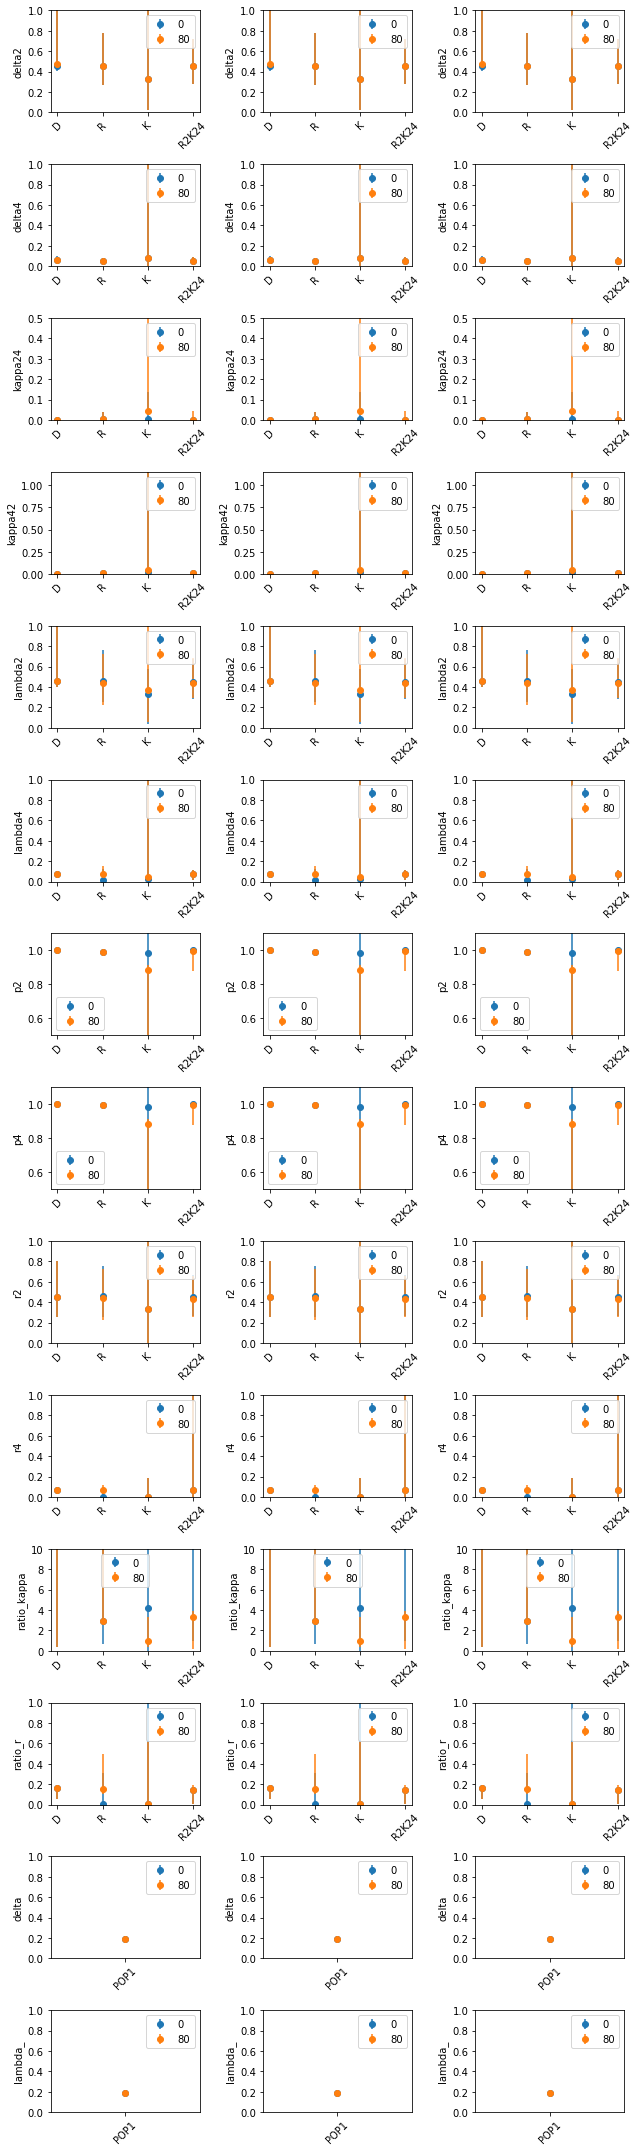

In [43]:
p_names = parameters['parameter'].unique()
# paras = [parameters, parameters_young, parameters_old]
paras = 3*[parameters]
fig, axss = plt.subplots(len(p_names), len(paras), figsize=(9, 30))



ylimits = {'delta2': (0, 1),
           'p2': (0.5, 1.1),
           'p4': (0.5, 1.1),
           'kappa24': (0, 0.5),
           'kappa42': (0, 1.15),
          'ratio_kappa': (0, 10)}

for parameter, axs in zip(p_names, axss):
    for para, ax in zip(paras, axs):
        data = para[para['parameter'] == parameter]
        for time, time_data in data.groupby('time'):
            ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
                        data=time_data, marker='o', ls='None', label=time)
            ax.legend()
            ax.set_ylabel(parameter)
        try:
            ax.set_ylim(ylimits[parameter])
        except:
            ax.set_ylim(0, 1)
        ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

## Export

In [109]:
# model = 'A'

# time = np.linspace(0, 100, 101)
# df = pd.DataFrame(results[model]['model'].get_implicit_parameters(time))[['r2', 'kappa24', 'ratio_r', 'p']]
# # df.columns=['r2', 'r4', 'kappa24', 'kappa42', 'ratio_r']
# df['r4'] = results[model]['model'].r4
# df['kappa42'] = results[model]['model'].kappa42
# df['delta2'] = results[model]['model'].delta2
# df['delta4'] = results[model]['model'].delta4
# df['age'] = time
# df['ploidy'] = c14.models.liver.A().ploidy(df['age'])
# df.head()

# result = results[model]
# df = result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=time).unstack().reset_index()

# df = df[['time', 'point_estimate']]

# df.to_excel('../../../results/parameters_A.xlsx')

## Model selection

In [33]:
# results_backup = results.copy()

In [40]:
results = results_backup.copy()

In [41]:
_ = results.pop('POP1', None)

In [42]:
model_selection_results = pd.DataFrame(
    pd.Series(
        {name: result['op'].calc_aicc(result['point_estimate'])
         for name, result in results.items()}, name='cAIC'))
model_selection_results['loglike'] = [result['op'].loglike_dict(result['point_estimate']) for name, result in results.items()]
model_selection_results['nparas'] = [result['model'].nparas for name, result in results.items()] 
model_selection_results['nparas'] += 1
model_selection_results = pd.DataFrame(model_selection_results)
model_selection_results['delta'] = model_selection_results['cAIC'] - model_selection_results['cAIC'].min() 
model_selection_results['w'] = np.exp(-0.5*model_selection_results['delta']) / np.exp(-0.5*model_selection_results['delta']).sum()
model_selection_results['ER'] = model_selection_results['w'].max() / model_selection_results['w']
model_selection_results.sort_values('cAIC')

,cAIC,loglike,nparas,delta,w,ER
D,-195.901332,103.807809,5,0.000000,0.300460,1.000000
R,-195.530892,103.622589,5,0.370440,0.249658,1.203483
R2K24,-195.394908,103.554597,5,0.506424,0.233248,1.288156
K,-195.247127,103.480706,5,0.654206,0.216634,1.386944


In [111]:
# parameters = parameters.merge(model_selection_results, left_on='model', right_index=True)

In [ ]:
# parameters['log10_point_estimate'] = np.log10(parameters['point_estimate'])
# parameters['log10_lower'] = np.log10(parameters['lower'])
# parameters['log10_upper'] = np.log10(parameters['upper'])
# parameters.head()

# parameters['log10_error_lower'] = parameters['log10_point_estimate'] - parameters['log10_lower']
# parameters['log10_error_upper'] = -parameters['log10_point_estimate'] + parameters['log10_upper']

# parameters['log10_error'] = parameters[['log10_error_lower', 'log10_error_upper']].mean(axis='columns')

# parameters.head()

# def parameter_average(data):
#     parameter = data['parameter'].iloc[0]
#     log10_mean = np.average(data['log10_point_estimate'], weights=data['w'])
#     log10_error = np.average(
#         np.sqrt(data['log10_error']**2 + (data['log10_point_estimate'] - log10_mean)**2),
#         weights=data['w'])
#     point_estimate = 10**log10_mean
#     lower = 10**(log10_mean-log10_error)
#     upper = 10**(log10_mean+log10_error)
#     return pd.Series({
#         'point_estimate': point_estimate,
#         'lower': lower,
#         'upper': upper,
#         'model': 'average',
#         'ymin': point_estimate - lower,
#         'ymax': point_estimate + upper,
#         'log10_point_estimate': log10_mean,
#         'log10_error': log10_error
#     })

# rates = ["r2", "r4", "delta2", "delta4", "kappa24", "kappa42", "lambda2", "lambda4"]

# averaged_parameters = (parameters
#                        .query('parameter in @rates')
#                        .groupby(['time', 'parameter'])
#                        .apply(parameter_average)
#                        .reset_index()
#                         )

In [119]:
# parameters = pd.concat([parameters, averaged_parameters], axis='rows', sort=False)

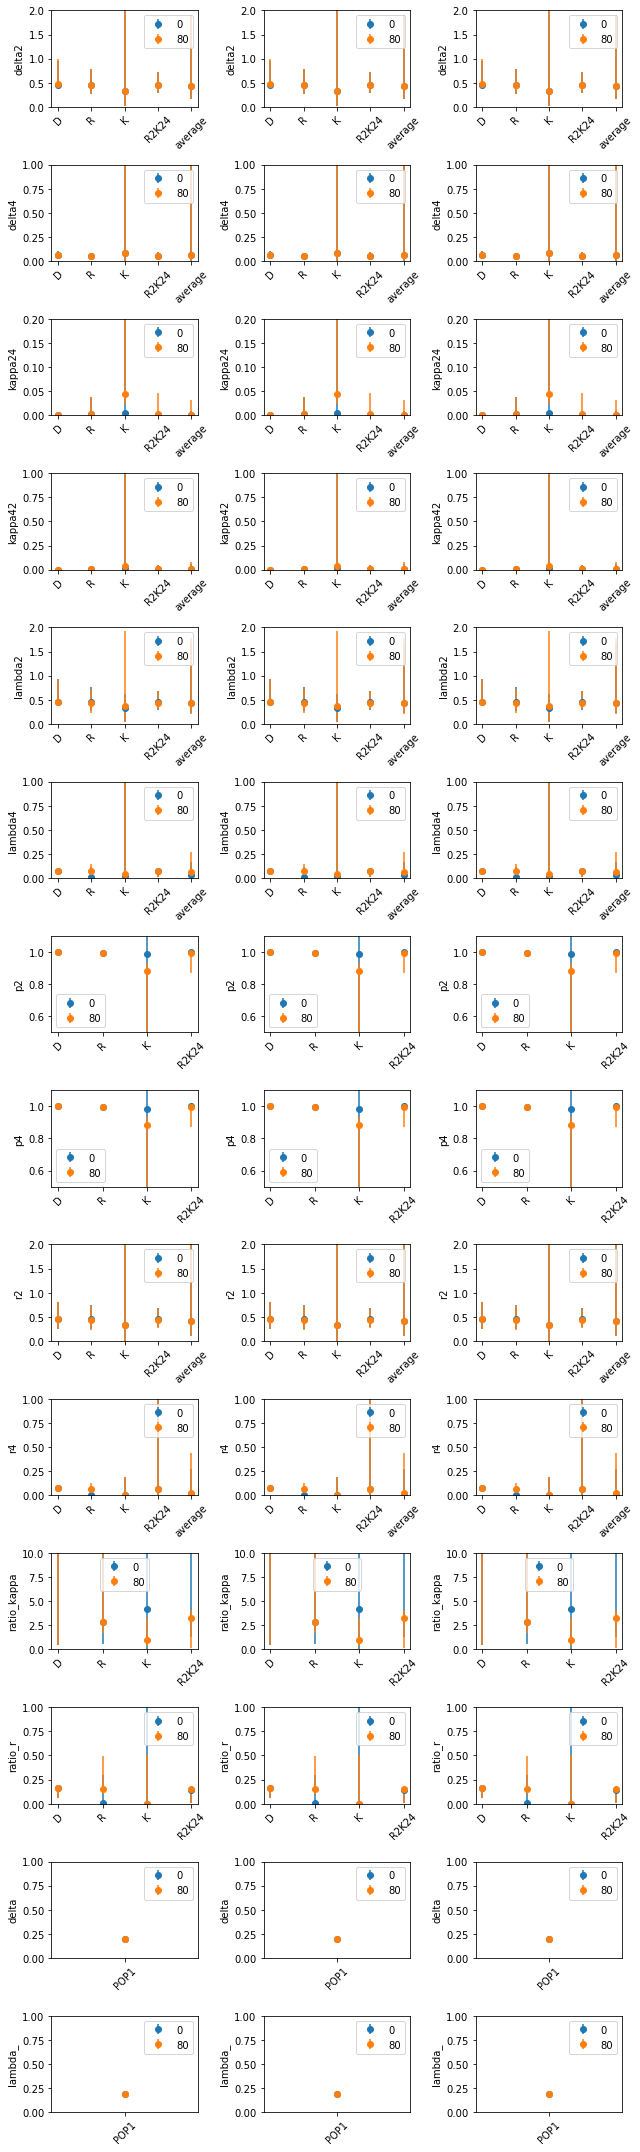

In [120]:
# p_names = parameters['parameter'].unique()
# paras = 3*[parameters]
# fig, axss = plt.subplots(len(p_names), len(paras), figsize=(9, 30))



# ylimits = {'delta2': (0, 2),
#            'delta4': (0, 1),
#            'lambda2': (0, 2),
#            'r2': (0, 2),
#            'p2': (0.5, 1.1),
#            'p4': (0.5, 1.1),
#            'kappa24': (0, 0.2),
#           'ratio_kappa': (0, 10)}

# for parameter, axs in zip(p_names, axss):
#     for para, ax in zip(paras, axs):
#         data = para[para['parameter'] == parameter]
#         for time, time_data in data.groupby('time'):
#             ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
#                         data=time_data, marker='o', ls='None', label=time)
#             ax.legend()
#             ax.set_ylabel(parameter)
#         try:
#             ax.set_ylim(ylimits[parameter])
#         except:
#             ax.set_ylim(0, 1)
#         ax.tick_params(axis='x', labelrotation=45)

# plt.tight_layout()
# plt.show()